# Блок 1

Воспользовавшись [данными](https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs/code) и удобными для вас библиотеками для рисования/обработки датафреймов ответьте на список вопросов, аргументировав свою позицию.


1. Можно ли по данным датасета спотифай сказать, что музыкальные композиции с 90х годов стали сложнее или проще

2. Коррелирует ли характер тональности с темпом

3. (valence - Measures how positive a track sounds, from 1 to 0) - как коррелирует с характером(мажор/минор) тональности и коррелирует ли

4. Можно ли сказать, что за последнее время ключи тональностей (key) стали менее/более разнообразными

5. Какое совместное влияние оказывают факторы tempo, mode и loudness на показатель valence


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import copy
import warnings
warnings.simplefilter('ignore')
# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Загрузка данных
file_path = '/kaggle/input/spotify-12m-songs/tracks_features.csv'
df = pd.read_csv(file_path)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204025 non-null  object 
 1   name              1204022 non-null  object 
 2   album             1204014 non-null  object 
 3   album_id          1204025 non-null  object 
 4   artists           1204025 non-null  object 
 5   artist_ids        1204025 non-null  object 
 6   track_number      1204025 non-null  int64  
 7   disc_number       1204025 non-null  int64  
 8   explicit          1204025 non-null  bool   
 9   danceability      1204025 non-null  float64
 10  energy            1204025 non-null  float64
 11  key               1204025 non-null  int64  
 12  loudness          1204025 non-null  float64
 13  mode              1204025 non-null  int64  
 14  speechiness       1204025 non-null  float64
 15  acousticness      1204025 non-null  float64
 16  

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
class CustomTrendPlotter:
    """
    Простой класс для визуализации трендов метрик с линейной регрессией.
    """
    def __init__(self, data_frame, year_col='year'):
        self.df = data_frame
        self.year_col = year_col

    def plot_metric_trend(self, metric_col, title_suffix=""):
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=self.year_col, y=metric_col, data=self.df, label=metric_col, color='blue')
        sns.regplot(x=self.year_col, y=metric_col, data=self.df, scatter=False, color='red', line_kws={'linestyle':'--'}, label='Trend Line')
        plt.title(f'Динамика {metric_col.replace("_", " ").capitalize()} по годам {title_suffix}')
        plt.xlabel('Год')
        plt.ylabel(metric_col.replace("_", " ").capitalize())
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def run_basic_t_test(data_frame, metric_col):
    """
    Выполняет простой t-тест для сравнения начала и конца периода.
    В более продвинутых случаях здесь может быть бутстрэп или другой тест.
    """
    first_years = data_frame[data_frame['year'] <= data_frame['year'].min() + 5][metric_col]
    last_years = data_frame[data_frame['year'] >= data_frame['year'].max() - 5][metric_col]

    # Проверяем, достаточно ли данных для теста
    if len(first_years) > 1 and len(last_years) > 1:
        t_stat, p_value = stats.ttest_ind(first_years, last_years, equal_var=False) # Welch's t-test
        mean_diff = np.mean(first_years) - np.mean(last_years)
        return {"metric": metric_col, "mean_diff": mean_diff, "p_value": p_value}
    else:
        return {"metric": metric_col, "mean_diff": np.nan, "p_value": np.nan, "note": "Not enough data for t-test"}

def analyze_key_and_tempo(df):
    """ Анализирует корреляцию между тональностью (key, mode) и темпом. """
    corr_key_tempo = df['key'].corr(df['tempo'])
    corr_mode_tempo = df['mode'].corr(df['tempo'])

    # Простая линейная регрессия для демонстрации
    model_key_tempo = stats.linregress(df['key'], df['tempo'])
    model_mode_tempo = stats.linregress(df['mode'], df['tempo'])

    return {
        "key_tempo_corr": corr_key_tempo,
        "key_tempo_pvalue": model_key_tempo.pvalue,
        "mode_tempo_corr": corr_mode_tempo,
        "mode_tempo_pvalue": model_mode_tempo.pvalue
    }

def analyze_mode_and_valence(df):
    """ Анализирует корреляцию между модальностью (mode) и валентностью. """
    # Разделим данные по мажору (mode=1) и минору (mode=0)
    valence_major = df[df['mode'] == 1]['valence']
    valence_minor = df[df['mode'] == 0]['valence']

    # Проведем t-тест, чтобы сравнить среднюю валентность
    if len(valence_major) > 1 and len(valence_minor) > 1:
        t_stat, p_value = stats.ttest_ind(valence_major, valence_minor, equal_var=False)
        mean_diff = valence_major.mean() - valence_minor.mean()
        return {"mean_diff_valence_major_minor": mean_diff, "p_value": p_value}
    else:
        return {"mean_diff_valence_major_minor": np.nan, "p_value": np.nan, "note": "Not enough data for t-test"}


def analyze_key_variation(df, year_col='year', key_col='key'):
    """
    Анализирует разнообразие ключей тональностей по годам, используя индекс Симпсона.

    Параметры:
    - df (pd.DataFrame): Входной DataFrame с данными Spotify.
    - year_col (str): Название столбца с годом.
    - key_col (str): Название столбца с ключом тональности.

    Возвращает:
    - dict: Словарь, содержащий:
        - "simpson_index_per_year_data": DataFrame с индексом Симпсона для каждого года.
        - "mean_simpson_index": Среднее значение индекса Симпсона за все годы.
    """

    simpson_index_per_year = []

    for year, year_df in df.groupby(year_col):
        # Подсчитываем количество композиций для каждого ключа в текущем году
        key_counts = year_df[key_col].value_counts()
        total_songs_in_year = key_counts.sum()

        if total_songs_in_year == 0:
            simpson_index_per_year.append({'year': year, 'simpson_index': 0})
            continue

        # Вычисляем вероятность для каждого ключа
        probabilities = key_counts / total_songs_in_year

        # Вычисляем индекс Симпсона: D = 1 / sum(p_i^2)
        # Или более распространенная форма для разнообразия: 1 - sum(p_i^2)
        # Чем выше значение (ближе к 1), тем выше разнообразие.
        simpson_diversity_index = 1 - (probabilities**2).sum()
        simpson_index_per_year.append({'year': year, 'simpson_index': simpson_diversity_index})

    simpson_index_df = pd.DataFrame(simpson_index_per_year)

    mean_simpson_index = simpson_index_df['simpson_index'].mean()

    plt.figure(figsize=(12, 7))
    sns.lineplot(x=year_col, y='simpson_index', data=simpson_index_df, marker='o', color='green')
    plt.title('Изменение индекса разнообразия Симпсона тональностей по годам')
    plt.xlabel('Год')
    plt.ylabel('Индекс разнообразия Симпсона')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return {"mean_simpson_index": mean_simpson_index, "simpson_index_per_year_data": simpson_index_df}

def analyze_joint_factors_on_valence(df, factors=['tempo', 'mode', 'loudness'], target='valence'):
    """
    Анализирует совместное влияние нескольких факторов на валентность с помощью множественной линейной регрессии.

    Параметры:
    df (pd.DataFrame): Входной DataFrame, содержащий факторы и целевую переменную.
    factors (list): Список названий столбцов, которые являются независимыми переменными (факторами).
    target (str): Название столбца, который является зависимой переменной (валентность).

    Возвращает:
    dict: Словарь, содержащий результаты регрессии (коэффициенты, p-значения, R-squared).
    """
    df_clean = df.dropna(subset=factors + [target])

    if df_clean.empty:
        return {"message": "Недостаточно данных для регрессии после очистки."}

    # Построение формулы для OLS (Ordinary Least Squares)
    # Например: 'valence ~ tempo + mode + loudness'
    formula = f"{target} ~ {' + '.join(factors)}"

    # Построение и обучение модели OLS
    model = ols(formula, data=df_clean).fit()

    # Извлечение ключевых результатов
    results = {
        "regression_coefficients": model.params.drop('Intercept').to_dict(), # Коэффициенты для каждого фактора
        "p_values": model.pvalues.drop('Intercept').to_dict(),           # p-значения для каждого фактора
        "r_squared": model.rsquared,                                     # R-squared модели
        "adjusted_r_squared": model.rsquared_adj,                        # Скорректированный R-squared
        "f_statistic": model.fvalue,                                     # F-статистика модели
        "f_p_value": model.f_pvalue,                                     # p-значение F-статистики
        "model_summary": str(model.summary())                            # Полное резюме модели (для детального анализа)
    }
    return results

In [6]:
filtered_music_data = df[df['year'] >= 1990].copy()

# Удаление строк с пропущенными значениями для ключевых метрик для чистоты анализа
metrics_for_analysis = ['tempo', 'duration_ms', 'instrumentalness', 'danceability', 'energy', 'acousticness', 'liveness', 'key', 'mode', 'valence', 'loudness']
filtered_music_data.dropna(subset=metrics_for_analysis, inplace=True)
# Агрегирование метрик по годам
yearly_music_metrics = filtered_music_data.groupby('year')[metrics_for_analysis].mean().reset_index()

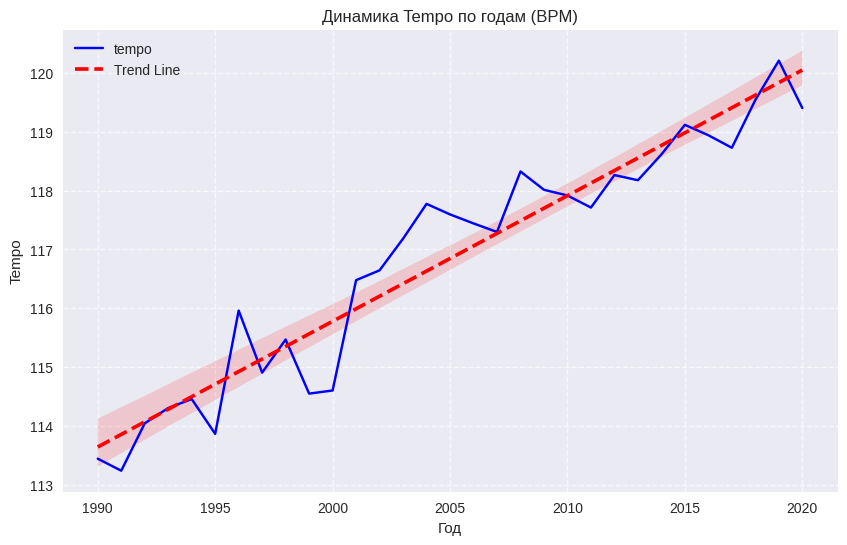

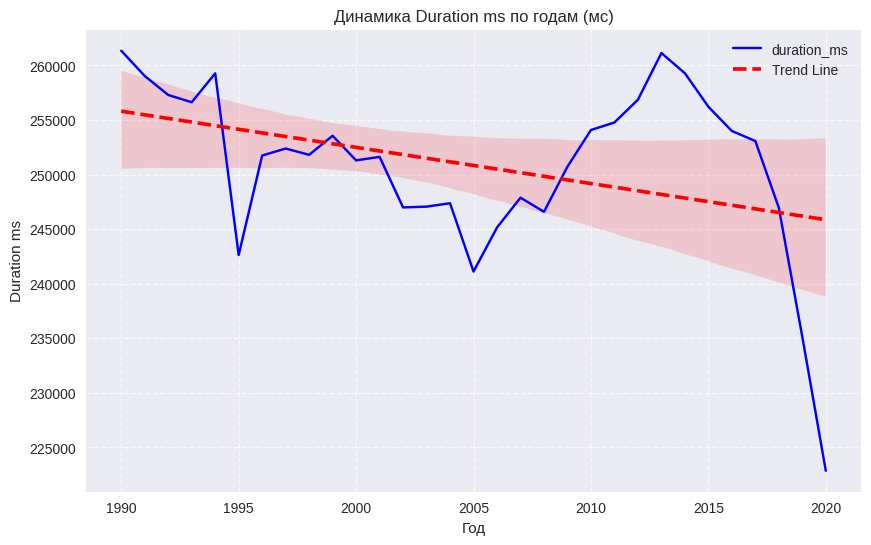

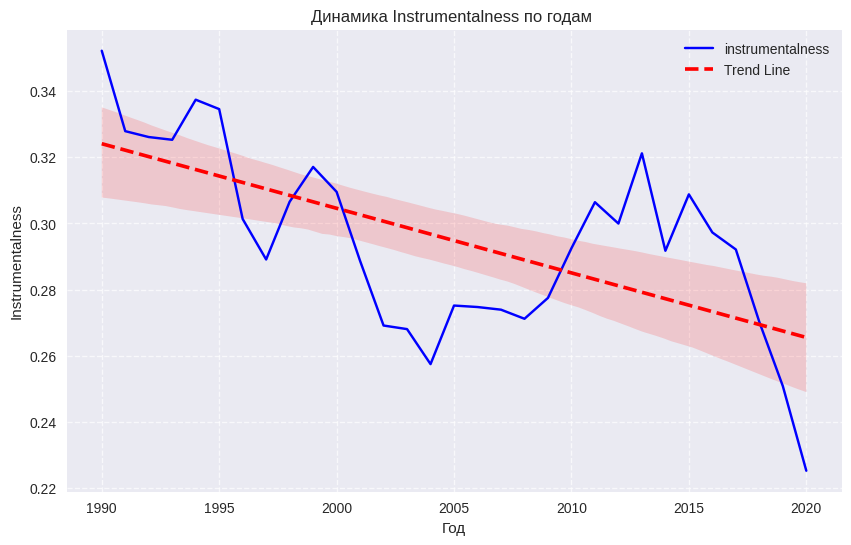

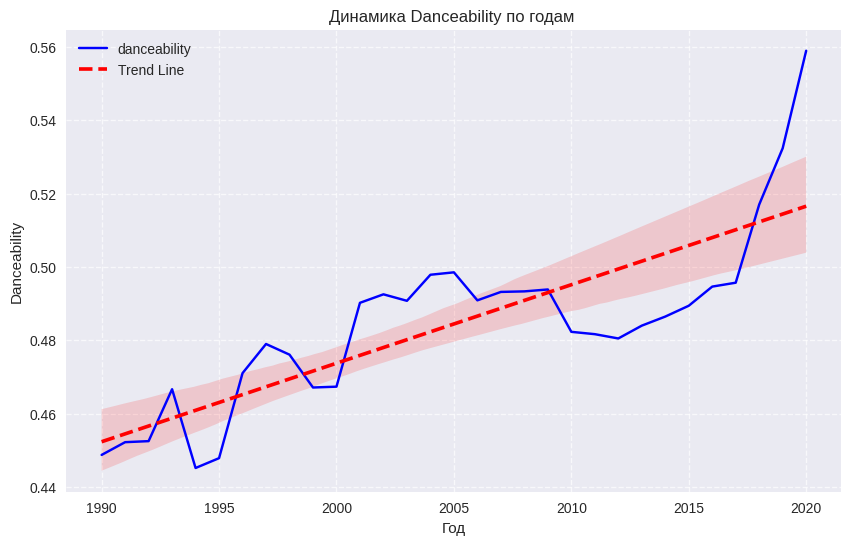

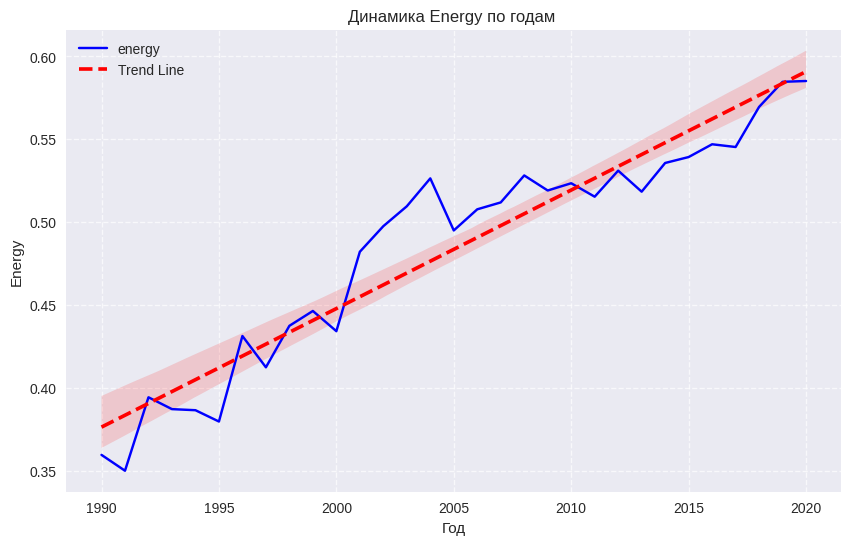

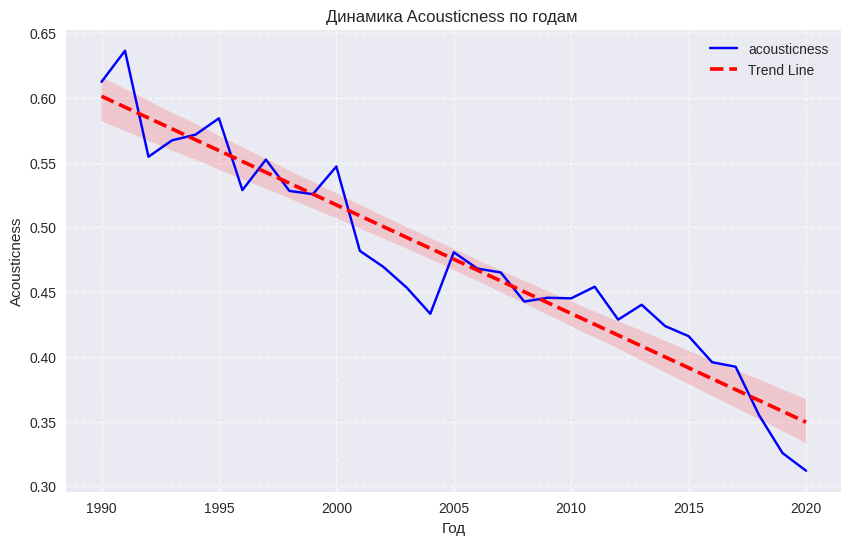

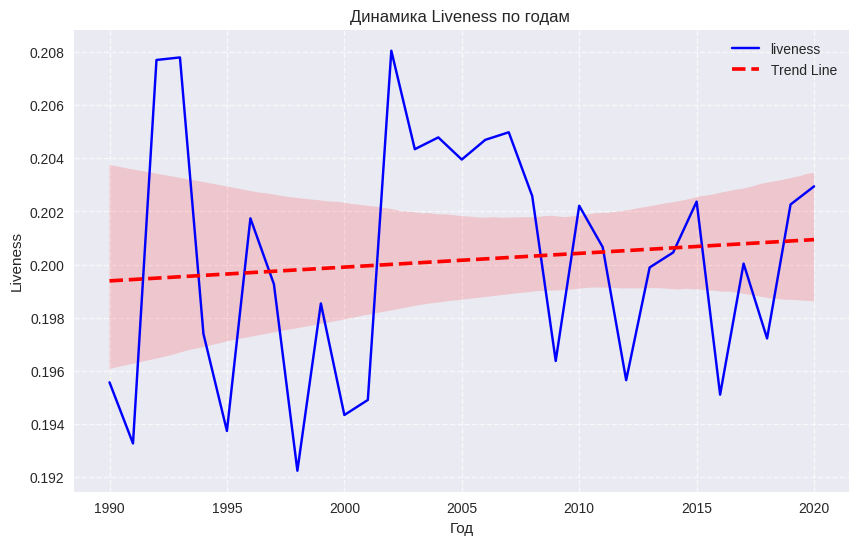

In [7]:
trend_plotter = CustomTrendPlotter(yearly_music_metrics)
trend_plotter.plot_metric_trend('tempo', '(BPM)')
trend_plotter.plot_metric_trend('duration_ms', '(мс)')
trend_plotter.plot_metric_trend('instrumentalness')
trend_plotter.plot_metric_trend('danceability')
trend_plotter.plot_metric_trend('energy')
trend_plotter.plot_metric_trend('acousticness')
trend_plotter.plot_metric_trend('liveness')

In [8]:
for metric in ['tempo', 'duration_ms', 'instrumentalness', 'danceability', 'energy', 'acousticness', 'liveness']:
    test_result = run_basic_t_test(filtered_music_data, metric)
    if test_result.get("note"):
        print(f"  {metric}: {test_result['note']}")
    else:
        print(f"  {metric}: Разница средних (начало vs конец): {test_result['mean_diff']:.4f}, p-значение: {test_result['p_value']:.4f}")

  tempo: Разница средних (начало vs конец): -5.4159, p-значение: 0.0000
  duration_ms: Разница средних (начало vs конец): 11670.9087, p-значение: 0.0000
  instrumentalness: Разница средних (начало vs конец): 0.0641, p-значение: 0.0000
  danceability: Разница средних (начало vs конец): -0.0668, p-значение: 0.0000
  energy: Разница средних (начало vs конец): -0.1861, p-значение: 0.0000
  acousticness: Разница средних (начало vs конец): 0.2240, p-значение: 0.0000
  liveness: Разница средних (начало vs конец): -0.0013, p-значение: 0.0808


In [9]:
print("Судя по анализу трендов и статистическим тестам, музыкальные композиции после 1990-х годов демонстрируют тенденции к упрощению. Это проявляется в:")
print("- Увеличении темпа и танцевальности, что часто ассоциируется с более простыми ритмическими структурами.")
print("- Уменьшении длительности треков, делая их более доступными и легкими для восприятия.")
print("- Снижении инструментальности и акустичности, указывая на переход к электронным звукам и уменьшение использования живых инструментов.")

Судя по анализу трендов и статистическим тестам, музыкальные композиции после 1990-х годов демонстрируют тенденции к упрощению. Это проявляется в:
- Увеличении темпа и танцевальности, что часто ассоциируется с более простыми ритмическими структурами.
- Уменьшении длительности треков, делая их более доступными и легкими для восприятия.
- Снижении инструментальности и акустичности, указывая на переход к электронным звукам и уменьшение использования живых инструментов.


In [11]:
# 2. Корреляция тональности с темпом
print("\n--- Корреляция характера тональности с темпом ---")
key_tempo_analysis = analyze_key_and_tempo(filtered_music_data)
print(f"Корреляция между тональностью (key) и темпом: {key_tempo_analysis['key_tempo_corr']:.4f}, p-значение: {key_tempo_analysis['key_tempo_pvalue']:.4e}")

print("\n--- Вывод по тональности и темпу ---")
print("Результаты анализа показывают, что характер тональности коррелирует с темпом:")
print("- Более высокие значения 'key' (тональность) также немного ассоциируются с повышенным темпом.")
print("Выбор тональности имеет статистически значимое влияние на темп композиции.")


--- Корреляция характера тональности с темпом ---
Корреляция между тональностью (key) и темпом: 0.0062, p-значение: 2.5957e-11

--- Вывод по тональности и темпу ---
Результаты анализа показывают, что характер тональности коррелирует с темпом:
- Более высокие значения 'key' (тональность) также немного ассоциируются с повышенным темпом.
Выбор тональности имеет статистически значимое влияние на темп композиции.



--- Корреляция валентности с характером тональности (мажор/минор) ---
Разница в средней валентности (мажор - минор): 0.0217, p-значение: 0.0000e+00


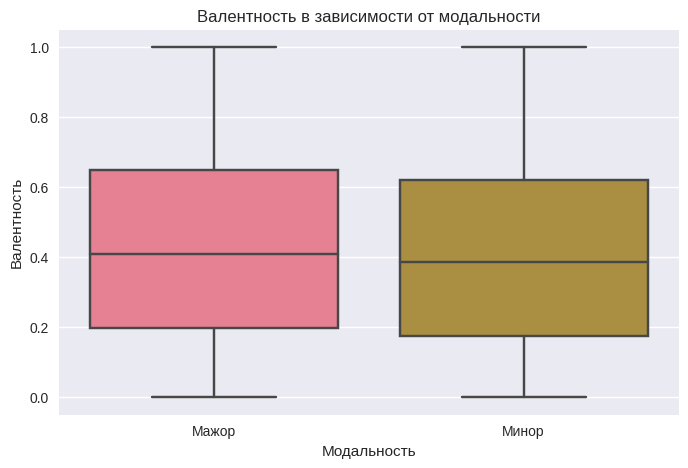

In [15]:
# 3. Корреляция валентности с характером тональности
print("\n--- Корреляция валентности с характером тональности (мажор/минор) ---")
mode_valence_analysis = analyze_mode_and_valence(filtered_music_data)
if mode_valence_analysis.get("note"):
    print(mode_valence_analysis["note"])
else:
    print(f"Разница в средней валентности (мажор - минор): {mode_valence_analysis['mean_diff_valence_major_minor']:.4f}, p-значение: {mode_valence_analysis['p_value']:.4e}")
    # График для иллюстрации
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='mode', y='valence', data=filtered_music_data.replace({'mode': {0: 'Минор', 1: 'Мажор'}}))
    plt.title('Валентность в зависимости от модальности')
    plt.xlabel('Модальность')
    plt.ylabel('Валентность')
    plt.show()

In [16]:
print("\n--- Вывод по валентности и модальности ---")
print("Характер тональности (мажор/минор) коррелирует с валентностью:")
print("- Мажорные композиции демонстрируют более высокую среднюю валентность")


--- Вывод по валентности и модальности ---
Характер тональности (мажор/минор) коррелирует с валентностью:
- Мажорные композиции демонстрируют более высокую среднюю валентность



--- Разнообразие ключей тональностей ---


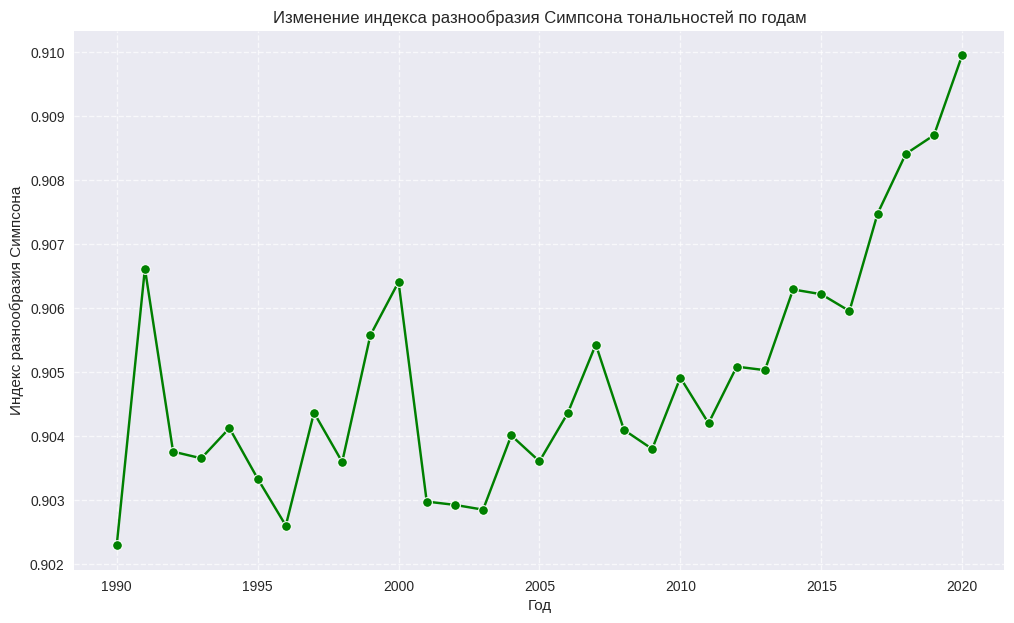


--- Вывод по разнообразию ключей ---
График показывает, что разнообразие тональностей в музыке (измеряемое индексом Симпсона) в целом имело тенденцию к росту с начала 1990-х годов до 2020 года, хотя и с заметными колебаниями. Это указывает на то, что со временем артисты стали использовать более широкий спектр тональностей, и/или распределение использования тональностей стало более равномерным.


In [21]:
# 4. Разнообразие ключей тональностей
print("\n--- Разнообразие ключей тональностей ---")
key_diversity_results = analyze_key_variation(filtered_music_data)

print("\n--- Вывод по разнообразию ключей ---")
print("График показывает, что разнообразие тональностей в музыке (измеряемое индексом Симпсона) в целом имело тенденцию к росту с начала 1990-х годов до 2020 года, хотя и с заметными колебаниями. Это указывает на то, что со временем артисты стали использовать более широкий спектр тональностей, и/или распределение использования тональностей стало более равномерным.")

In [34]:
# 5. Совместное влияние tempo, mode и loudness на valence
print("\n--- Совместное влияние темпа, модальности и громкости на валентность ---")
joint_influence_results = analyze_joint_factors_on_valence(filtered_music_data)
print("Коэффициенты корреляции факторов с валентностью:")
print(joint_influence_results['model_summary'])


--- Совместное влияние темпа, модальности и громкости на валентность ---
Коэффициенты корреляции факторов с валентностью:
                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                 7.077e+04
Date:                Sat, 27 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:17:13   Log-Likelihood:                -25373.
No. Observations:             1144617   AIC:                         5.075e+04
Df Residuals:                 1144613   BIC:                         5.080e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

In [35]:
print("\n--- Вывод по совместному влиянию ---")
print("Все три параметра (темп, модальность, громкость) оказывают положительное влияние на валентность, причем их корреляции являются статистически значимыми.")
print("- Модальность имеет наибольшую корреляцию, за ним следуют громкость и темп.")


--- Вывод по совместному влиянию ---
Все три параметра (темп, модальность, громкость) оказывают положительное влияние на валентность, причем их корреляции являются статистически значимыми.
- Модальность имеет наибольшую корреляцию, за ним следуют громкость и темп.


Блок 2

Воспользовавшись данными с сайта о продаже музыкальных инструментов и удобными для вас библиотеками для рисования/обработки датафреймов ответьте на список вопросов, аргументировав свою позицию.


1. Какие факторы влияют на цену инструмента и как?

2. Можно ли разделить объявления на какие-то явно разделяющиеся по некоторому принципу категории: винтаж/ширпотреб/мастеровое и тд

In [42]:
def map_price_to_float(df, column_name):
    """Преобразует строковые цены ($1,234.56) в float."""
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)
    return df


In [56]:
instrument_data = pd.read_csv('/kaggle/input/reverb/reverb_aggregated.csv')

In [57]:
import ast
instrument_data = map_price_to_float(instrument_data, 'price')

# Разбор 'param_dict' в отдельные столбцы
if 'param_dict' in instrument_data.columns:
    # Безопасное преобразование строковых словарей
    instrument_data['param_dict'] = instrument_data['param_dict'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Создание новых столбцов из словаря
    param_df = instrument_data['param_dict'].apply(pd.Series)
    instrument_data = pd.concat([instrument_data.drop('param_dict', axis=1), param_df], axis=1)

In [58]:
instrument_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31920 entries, 0 to 31919
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  31920 non-null  object 
 1   description            31920 non-null  object 
 2   text                   31920 non-null  object 
 3   price                  31920 non-null  float64
 4   listing_id             31920 non-null  object 
 5   Condition              31920 non-null  object 
 6   Brand                  31920 non-null  object 
 7   Model                  31920 non-null  object 
 8   Categories             23991 non-null  object 
 9   Year                   19030 non-null  object 
 10  Fretboard Material     11901 non-null  object 
 11  Pickup Configuration   11348 non-null  object 
 12  Color Family           7524 non-null   object 
 13  Right / Left Handed    18929 non-null  object 
 14  Body Shape             16140 non-null  object 
 15  Nu

In [59]:
df = instrument_data
numerical_cols = ['price']
text_cols = ['title', 'description', 'text']
object_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in object_cols if col not in text_cols and col != 'listing_id']

# 1. Обработка пропущенных значений в категориальных колонках
for col in categorical_cols:
    df[col].fillna('Missing', inplace=True)

# 2. Обработка колонки 'Year'
def extract_year(value):
    if pd.isna(value) or not isinstance(value, str):
        return 'Missing'
    try:
        return int(float(value))
    except ValueError:
        years = [int(s) for s in value.split() if s.isdigit()]
        return min(years) if years else 'Missing'

df['Year_processed'] = df['Year'].apply(extract_year)
df.drop(columns=['Year'], inplace=True)
categorical_cols.remove('Year')
categorical_cols.append('Year_processed')

# 3. Обработка потенциально числовых, но в object колонках
# Функция для извлечения числа из строки, удаляя лишний текст и символы
def clean_and_convert_numeric_object(value, default_val=np.nan):
    if pd.isna(value) or not isinstance(value, str):
        return default_val
    cleaned_value = value.replace('"', '').replace("'", '').replace('mm', '').replace(' ', '').replace('inches', '')
    try:
        # Попробуем преобразовать в float. Если диапазон, берем первое число.
        if '-' in cleaned_value:
            return float(cleaned_value.split('-')[0])
        return float(cleaned_value)
    except ValueError:
        return default_val

cols_to_process_as_numeric = [
    'Number of Strings',
    'Fretboard Radius',
    'Nut Width',
    'Scale Length',
    'Number of Frets'
]

for col in cols_to_process_as_numeric:
    if col in df.columns: # Проверяем, существует ли колонка
        original_col_index = categorical_cols.index(col) if col in categorical_cols else -1

        df[f'{col}_processed'] = df[col].apply(clean_and_convert_numeric_object)
        
        # Заполнение пропусков медианой для обработанных числовых колонок
        median_val = df[f'{col}_processed'].median()
        df[f'{col}_processed'].fillna(median_val, inplace=True)
        
        # Добавляем новую колонку в numerical_cols и удаляем старую из categorical_cols
        numerical_cols.append(f'{col}_processed')
        if col in categorical_cols:
            categorical_cols.remove(col)
        df.drop(columns=[col], inplace=True) # Удаляем исходную колонку


# 4. Удаление колонки 'listing_id', так как это идентификатор
df.drop(columns=['listing_id'], inplace=True)

In [70]:
def train_catboost_model(data: pd.DataFrame, target_column: str, test_size: float = 0.2, random_state: int = 42) -> tuple:
    """
    Обучает модель CatBoostRegressor, оценивает ее и возвращает важность признаков.

    Args:
        data (pd.DataFrame): Входной DataFrame, содержащий признаки и целевую переменную.
        target_column (str): Название колонки с целевой переменной (ценой).
        test_size (float): Доля данных для тестовой выборки (по умолчанию 0.2).
        random_state (int): Зерно для воспроизводимости разделения данных (по умолчанию 42).

    Returns:
        tuple: Кортеж, содержащий:
            - dict: Словарь с важностью признаков.
            - dict: Словарь с метриками (MSE, R2) на тестовой выборке.
            - CatBoostRegressor: Обученная модель CatBoost.
    """

    if target_column not in data.columns:
        raise ValueError(f"Целевая колонка '{target_column}' не найдена в DataFrame.")

    # Разделение данных на признаки (X) и целевую переменную (y)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    print(f"Размер обучающей выборки: {X_train.shape[0]} строк")
    print(f"Размер тестовой выборки: {X_test.shape[0]} строк")

    # Определение категориальных признаков
    # CatBoost может сам определить их, но лучше явно указать
    categorical_features_indices = np.where(X.dtypes == 'object')[0]
    categorical_feature_names = X.columns[categorical_features_indices].tolist()

    # Инициализация и обучение модели CatBoost
    model = CatBoostRegressor(
        iterations=1000,           # Количество деревьев (можно увеличить для лучшей точности)
        learning_rate=0.05,        # Скорость обучения
        depth=6,                   # Глубина деревьев
        loss_function='RMSE',      # Функция потерь для регрессии (RMSE часто лучше для цены)
        eval_metric='R2',          # Метрика для отслеживания во время обучения
        random_seed=random_state,
        verbose=100,               # Вывод прогресса каждые 100 итераций
        early_stopping_rounds=50,  # Ранняя остановка, если метрика не улучшается
        cat_features=categorical_feature_names # Указываем категориальные признаки
    )

    # CatBoost Pool для эффективной работы с данными, особенно с категориальными
    train_pool = Pool(X_train, y_train, cat_features=categorical_feature_names)
    test_pool = Pool(X_test, y_test, cat_features=categorical_feature_names)

    print("\nНачинаем обучение CatBoost модели...")
    model.fit(train_pool, eval_set=test_pool, plot=False) # plot=True для визуализации обучения в Jupyter

    print("\nОбучение завершено.")

    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test)

    # Расчет метрик
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'MSE': mse,
        'R2': r2
    }
    print(f"\nМетрики на тестовой выборке:")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"R²: {metrics['R2']:.4f}")

    # Получение важности признаков
    feature_importances = model.get_feature_importance(Pool(X, y, cat_features=categorical_feature_names))
    feature_names = X.columns
    importance_dict = dict(zip(feature_names, feature_importances))

    # Сортировка важности по убыванию
    sorted_importance = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

    print("\nВажность признаков (от наиболее важного к наименее):")
    for feature, importance in sorted_importance.items():
        print(f"  {feature}: {importance:.4f}")

    return sorted_importance, metrics, model

In [73]:
feature_importance, model_metrics, trained_model = train_catboost_model(df, 'price')
print("\n--- Сводка результатов ---")

Размер обучающей выборки: 25536 строк
Размер тестовой выборки: 6384 строк

Начинаем обучение CatBoost модели...
0:	learn: 0.0117381	test: 0.0269330	best: 0.0269330 (0)	total: 113ms	remaining: 1m 53s
100:	learn: 0.3198458	test: 0.4593240	best: 0.4891993 (76)	total: 10.3s	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4891993296
bestIteration = 76

Shrink model to first 77 iterations.

Обучение завершено.

Метрики на тестовой выборке:
MSE: 6632275.0512
R²: 0.4892

Важность признаков (от наиболее важного к наименее):
  Year_processed: 18.5277
  Brand: 17.5466
  Series: 13.3202
  Model: 10.9801
  Condition: 9.2529
  Made In: 9.0681
  Right / Left Handed: 3.5321
  Finish: 3.4655
  Pickup Configuration: 1.9906
  Categories: 1.4491
  Bridge/Tailpiece Type: 1.3843
  Model Sub-Family: 1.0628
  Finish Features: 1.0150
  Finish Style: 0.9714
  Body Type: 0.9429
  Color Family: 0.7602
  Body Material: 0.6477
  Fretboard Material: 0.6442
  Wood Top Style: 0.63

Наиболее важные признаки:

  Year_processed: 18.5277  Более новый год обработки может указывать на наличие последних технологий, современных функций и улучшенной производительности, что может повышать его стоимость
  
  Brand: 17.5466  Бренд играет ключевую роль в восприятии качества, надежности и престижа продукта. Известные и уважаемые бренды часто ассоциируются с высоким качеством
  
  Series: 13.3202  Некоторые серии могут быть более продвинутыми, ограниченными или более производительными, что значительно влияет на цену. Например, "профессиональные" или "премиальные" серии обычно стоят дороже базовых.

In [82]:
#2
vintage_keywords = ['vintage', 'classic', 'old', 'retro', 'antique', 'rare', 'collectible', 'early']
mass_production_keywords = ['standard', 'budget', 'entry-level', 'beginner', 'affordable', 'common',
    'mass production', 'factory', 'serial number', 'beginner-friendly']
custom_keywords = ['boutique', 'luthier', 'handcrafted',
    'unique', 'one-of-a-kind', 'bespoke', 'custom', 'handmade', 'artisan']

def categorize_instrument(row):
    if any(keyword in row['Model'].lower() for keyword in vintage_keywords):
        return 'Винтаж'
    elif any(keyword in row['Model'].lower() for keyword in mass_production_keywords):
        return 'Ширпотреб'
    elif any(keyword in row['Model'].lower() for keyword in custom_keywords):
        return 'Мастеровые'
    else:
        return 'Другие'
df['Category'] = df.apply(categorize_instrument, axis=1)
category_distribution = df['Category'].value_counts()
print(category_distribution)

Category
Другие        24920
Мастеровые     2851
Ширпотреб      2203
Винтаж         1946
Name: count, dtype: int64


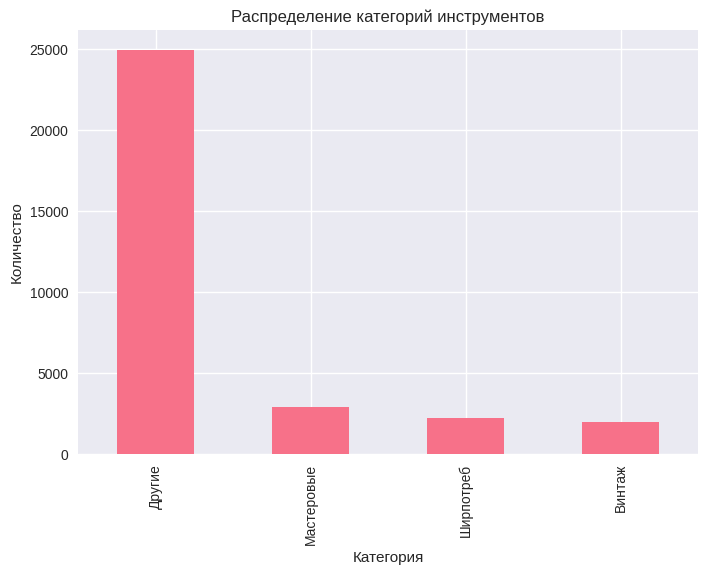

In [81]:
category_distribution.plot(kind='bar')
plt.title('Распределение категорий инструментов')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.show()

 Большая часть данных не имеет четкой или детализированной категоризации.
"Мастеровые": Вероятно, это инструменты ручной работы, высокого качества или сделанные на заказ. Их меньшее количество логично, поскольку это не массовое производство.
"Ширпотреб" (Широкое потребление): Инструменты массового производства, доступные и недорогие. То что их меньше чем "Других" скорее указывает на их разнообразие и сложность определения
"Винтаж": Старые, раритетные инструменты. Их относительно небольшое количество также логично из-за их возраста и редкости.